In [3]:
# imports
import json
import jsonlines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sb
from statistics import mean

# Synthetic data experiments

In [2]:
BORDA_BASE = "../new_data_gen/Data/history_file_synthetic_baseline_borda.json"
BORDA_LOT = "../new_data_gen/Data/history_file_synthetic_product_lottery_borda.json"
BORDA_WEIGHT = "../new_data_gen/Data/history_file_synthetic_weighted_alloc_borda.json"
BORDA_LEAST = "../new_data_gen/Data/history_file_synthetic_least_fair_borda.json"

COPELAND_BASE = "../new_data_gen/Data/history_file_synthetic_baseline_copeland.json"
COPELAND_LOT = "../new_data_gen/Data/history_file_synthetic_product_lottery_copeland.json"
COPELAND_WEIGHT = "../new_data_gen/Data/history_file_synthetic_weighted_alloc_copeland.json"
COPELAND_LEAST = "../new_data_gen/Data/history_file_synthetic_least_fair_copeland.json"

RP_BASE = "../new_data_gen/Data/history_file_synthetic_baseline_rankedpairs.json"
RP_LOT = "../new_data_gen/Data/history_file_synthetic_product_lottery_rankedpairs.json"
RP_WEIGHT = "../new_data_gen/Data/history_file_synthetic_weighted_alloc_rankedpairs.json"
RP_LEAST = "../new_data_gen/Data/history_file_synthetic_least_fair_rankedpairs.json"

WR_BASE = "../new_data_gen/Data/history_file_synthetic_baseline_weighted_rescore.json"
WR_LEAST = "../new_data_gen/Data/history_file_synthetic_least_fair_weighted_rescore.json"
WR_LOT = "../new_data_gen/Data/history_file_synthetic_product_lottery_weighted_rescore.json"
WR_WEIGHT = "../new_data_gen/Data/history_file_synthetic_weighted_alloc_weighted_rescore.json"

recs_file = "../new_data_gen/Data/recs.csv"
items_file = "../new_data_gen/Data/items.csv"

In [3]:
# reads recommender and item files
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])

In [4]:
# no need to change unless adding a new allocation mechanism
history_files = [BORDA_BASE, BORDA_LOT, BORDA_WEIGHT, BORDA_LEAST, COPELAND_BASE, COPELAND_LEAST,COPELAND_LOT,COPELAND_WEIGHT,RP_BASE, RP_LEAST,RP_LOT,RP_WEIGHT, WR_BASE, WR_LEAST, WR_LOT, WR_WEIGHT]

borda_b =[]
borda_lo = []
borda_w= []
borda_le = []
copeland_b =[]
copeland_le= []
copeland_lo = []
copeland_w= []
rp_b = []
rp_le = []
rp_lo= []
rp_w= []
wr_b = []
wr_le = []
wr_lo = []
wr_w = []



list_names = [borda_b, borda_lo, borda_w,borda_le,copeland_b, copeland_le,copeland_lo,copeland_w,rp_b,rp_le,rp_lo,rp_w,wr_b,wr_le,wr_lo,wr_w]
readable_names = ['Borda Baseline','Borda Lottery', 'Borda Weighted Product', 'Borda Least Fair', 'Copeland Baseline','Copeland Least Fair', 'Copeland Lottery', 'Copeland Weighted Product','Ranked Pairs Baseline','Ranked Pairs Least Fair', 'Ranked Pairs Lottery', 'Ranked Pairs Weighted Product', 'Weighted Rescore Baseline', 'Weighted Rescore Lottery', 'Weighted Rescore Product', 'Weighted Rescore Least Fair']

In [5]:
# define dictionaries for statistical analysis, change if adding new allocation mechanisms

results_borda_b = {}
results_borda_lo = {}
results_borda_w= {}
results_borda_le = {}
results_copeland_b = {}
results_copeland_le= {}
results_copeland_lo = {}
results_copeland_w= {}
results_rp_b = {}
results_rp_le = {}
results_rp_lo = {}
results_rp_w = {}
results_wr_b = {}
results_wr_le = {}
results_wr_lo = {}
results_wr_w = {}


dict_names = [results_borda_b,results_borda_lo, results_borda_w, results_borda_le, results_copeland_b,results_copeland_le, results_copeland_lo, results_copeland_w, results_rp_b,results_rp_le, results_rp_lo, results_rp_w, results_wr_b, results_wr_le, results_wr_lo, results_wr_w]

In [6]:
# read history files
for history_file, list_name in zip(history_files,list_names):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            list_name.append(obj)

In [7]:
# process history files into dictionaries for statistics
for list, dictionary in zip(list_names, dict_names):
    for line in list:
        results = line['choice_out']['results']
        results_list = []
        for item in results:
            results_list.append(item['item'])
        dictionary[line['user']] = results_list 

In [22]:
### STATISTICS FUNCTIONS ###

# get recommendation score based on user and item ids
def lookupscore(user, item):
    user = (user)
    item = int(item)
    score = recommender.loc[(recommender.User == user) & (recommender.Item == item)]["Score"]
    if not score.empty:
        score = score['Score']
    else:
        score = 0
    return float(score)

# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1):
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    return recdcg/idealdcg

# not currently run in this file
def plot_ndcg(name,ndcg_results):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == int(item_id))]["BV"]:
        feature_values.append(value)
    return feature_values



In [5]:
### VISUALIZATION FUNCTIONS ###
# TODO: Update viz functions to make them more efficient and inline with statistics

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['1'] == 0) & (alloc_df['2'] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]

def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)

def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    do_plots(experiment_data, include_none, image_prefix)


In [10]:
# generates average NDCG for each allocation mechanism and stores them in the list avg_of_ndcg
# also creates ndcg_results, a dictionary that allows plotting NDCG over time for each mechanism
avg_of_ndcg = []
ndcg_results = {}
for dictionary, name in zip(dict_names, readable_names):
    users = []
    ndcg_values = []
    for user, items in dictionary.items():
        scores = []
        for item in items:
            scores.append(lookupscore(user, item))
        ideal_scores = []
        for score in recommender.loc[(recommender.User == int(user))]["Score"].sort_values(ascending=False):
            ideal_scores.append(score)
            ideal_scores = ideal_scores[0:len(scores)+1]
        ndcg_values.append(ndcg(scores, ideal_scores))
        users.append(user)
    avg_of_ndcg.append(mean(ndcg_values))
    ndcg_results[name] = {"Users":users, "NDCG":ndcg_values}

In [11]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=readable_names, columns=["NDCG"])
ndcg_table

,NDCG
Borda Baseline,0.974456
Borda Lottery,0.799502
Borda Weighted Product,0.826576
Borda Least Fair,0.807565
Copeland Baseline,0.974456
Copeland Least Fair,0.744433
Copeland Lottery,0.732881
Copeland Weighted Product,0.904031
Ranked Pairs Baseline,0.974456
Ranked Pairs Least Fair,0.913423


In [12]:
# calculates proportional fairness for the representation of item features
# currently designed to handle two three features
# TODO: make it easier to change number of item features
either_fairness = []
f1_representation = []
f2_representation = []

for dictionary, name in zip(dict_names, readable_names):
    item_counter = 0
    f0 = 0
    f1 = 0
    f2 = 0
    either = 0
    for items in dictionary.values():
        for item in items:
            item_counter += 1
            list_of_features = get_item_features(item)
            if list_of_features[0] == 1:
                f0 += 1
            if list_of_features[1] == 1:
                f1 += 1
            if list_of_features[2] == 1:
                f2 += 1
            if list_of_features[1] == 1 or list_of_features[2] == 1:
                either += 1
    either_fairness.append(either/item_counter)
    f1_representation.append(f1/item_counter)
    f2_representation.append(f2/item_counter)

In [13]:
# calculates average fairness in relation to threshold
agent1 = ['1']
prop1 = .25
agent2 = ['2']
prop2 = .25
fairness_results = {"Protected":either_fairness,"1":f1_representation,"2":f2_representation}
prop_fairness_results = pd.DataFrame(data=fairness_results, index=readable_names)
prop_fairness_results['score1'] = prop_fairness_results[agent1]/prop1
prop_fairness_results['score2'] = prop_fairness_results[agent2]/prop2
prop_fairness_results['Average Fairness Score'] = (prop_fairness_results['score1']+prop_fairness_results['score2'])/2

In [30]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)

In [31]:
ndcg_fairness

,Protected,1,2,score1,score2,Average Fairness Score,NDCG
Borda Baseline,0.1354,0.0850,0.0552,0.3400,0.2208,0.2804,0.974456
Borda Lottery,0.2808,0.1460,0.1508,0.5840,0.6032,0.5936,0.799502
Borda Weighted Product,0.2716,0.1372,0.1504,0.5488,0.6016,0.5752,0.826576
Borda Least Fair,0.2804,0.1488,0.1476,0.5952,0.5904,0.5928,0.807565
Copeland Baseline,0.1354,0.0850,0.0552,0.3400,0.2208,0.2804,0.974456
Copeland Least Fair,0.3274,0.1736,0.1720,0.6944,0.6880,0.6912,0.744433
Copeland Lottery,0.3320,0.1692,0.1810,0.6768,0.7240,0.7004,0.732881
Copeland Weighted Product,0.2034,0.0974,0.1242,0.3896,0.4968,0.4432,0.904031
Ranked Pairs Baseline,0.1354,0.0850,0.0552,0.3400,0.2208,0.2804,0.974456
Ranked Pairs Least Fair,0.2114,0.1136,0.1100,0.4544,0.4400,0.4472,0.913423


In [32]:
baseline_accuracy = ndcg_fairness.iloc[0,6]

In [34]:
ndcg_fairness.loc[0:4, "Choice"] = "Borda"
ndcg_fairness.loc[4:8, "Choice"] = "Copeland"
ndcg_fairness.loc[8:12, "Choice"] = "Ranked Pairs"
ndcg_fairness.loc[12:16, "Choice"] = "Rescoring"

/var/folders/ch/z531hj1s0_b04rj17lswvh6w0000gn/T/ipykernel_17033/2983922378.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ndcg_fairness.loc[0:4, "Choice"] = "Borda"
/var/folders/ch/z531hj1s0_b04rj17lswvh6w0000gn/T/ipykernel_17033/2983922378.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ndcg_fairness.loc[4:8, "Choice"] = "Copeland"
/var/folders/ch/z531hj1s0_b04rj17lswvh6w0000gn/T/ipykernel_17033/2983922378.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ndcg_fairness.loc[8:12, "Choice"] = "Ranked Pairs"
/var/folders/ch/z531hj1s0_b04rj17lswvh6w0000gn/T/ipykernel_17033/2983922378.py:4: FutureWarning

In [35]:
#ndcg_fairness["Allocation"] = ndcg_fairness.apply(lambda x: x.name.replace(x["Choice"], ''), axis=1)

In [36]:
ndcg_fairness = ndcg_fairness.drop(["Borda Baseline", "Copeland Baseline", "Ranked Pairs Baseline", "Weighted Rescore Baseline"])

In [37]:
ndcg_fairness["Allocation"] = ''

In [38]:
ndcg_fairness.iloc[0,8] = "Lottery"
ndcg_fairness.iloc[1,8] = "Weighted"
ndcg_fairness.iloc[2,8] = "Least Fair"
ndcg_fairness.iloc[3:10:3,8] = "Least Fair"
ndcg_fairness.iloc[4:11:3,8] = "Lottery"
ndcg_fairness.iloc[5:12:3,8] = "Weighted"

In [39]:
ndcg_fairness

,Protected,1,2,score1,score2,Average Fairness Score,NDCG,Choice,Allocation
Borda Lottery,0.2808,0.1460,0.1508,0.5840,0.6032,0.5936,0.799502,Borda,Lottery
Borda Weighted Product,0.2716,0.1372,0.1504,0.5488,0.6016,0.5752,0.826576,Borda,Weighted
Borda Least Fair,0.2804,0.1488,0.1476,0.5952,0.5904,0.5928,0.807565,Borda,Least Fair
Copeland Least Fair,0.3274,0.1736,0.1720,0.6944,0.6880,0.6912,0.744433,Copeland,Least Fair
Copeland Lottery,0.3320,0.1692,0.1810,0.6768,0.7240,0.7004,0.732881,Copeland,Lottery
Copeland Weighted Product,0.2034,0.0974,0.1242,0.3896,0.4968,0.4432,0.904031,Copeland,Weighted
Ranked Pairs Least Fair,0.2114,0.1136,0.1100,0.4544,0.4400,0.4472,0.913423,Ranked Pairs,Least Fair
Ranked Pairs Lottery,0.2182,0.1162,0.1130,0.4648,0.4520,0.4584,0.909284,Ranked Pairs,Lottery
Ranked Pairs Weighted Product,0.1374,0.0868,0.0572,0.3472,0.2288,0.2880,0.973418,Ranked Pairs,Weighted
Weighted Rescore Lottery,0.2710,0.1430,0.1426,0.5720,0.5704,0.5712,0.899143,Rescoring,Least Fair


In [67]:
ndcg_fairness["Proportional Difference"] = ndcg_fairness.apply(lambda x: x["1"] - x["2"], axis=1)

In [68]:
ndcg_fairness["Normalized Difference"] = ndcg_fairness.apply(lambda x: x["score1"] - x["score2"], axis=1)

In [69]:
difference_table = ndcg_fairness[["Proportional Difference", "Normalized Difference"]]

In [70]:
difference_table = difference_table[0:16]

In [60]:
def make_scatterplot(fairness_df, base_ndcg, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Average Fairness Score',
                      y='NDCG',
                      data=fairness_df,
                      style="Allocation",
                      hue="Choice",
                      s=100,
                      markers={"Lottery": "^", "Weighted": "X", "Least Fair": "o"})

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


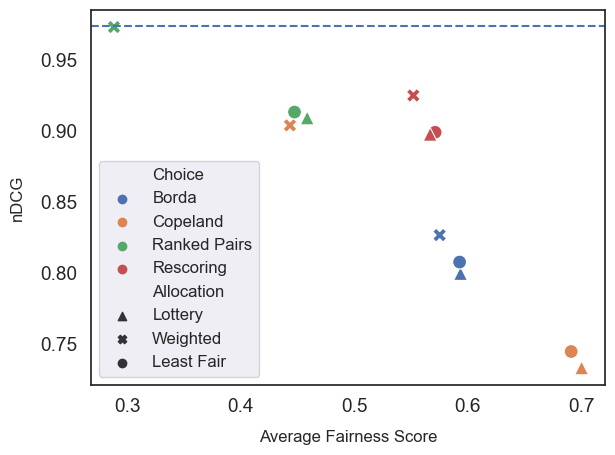

In [61]:
make_scatterplot(ndcg_fairness, baseline_accuracy, filename='synthetic_scatter.png')

In [29]:
baseline_accuracy

0.2804

In [71]:
difference_table


,Proportional Difference,Normalized Difference
Borda Lottery,-0.0048,-0.0192
Borda Weighted Product,-0.0132,-0.0528
Borda Least Fair,0.0012,0.0048
Copeland Least Fair,0.0016,0.0064
Copeland Lottery,-0.0118,-0.0472
Copeland Weighted Product,-0.0268,-0.1072
Ranked Pairs Least Fair,0.0036,0.0144
Ranked Pairs Lottery,0.0032,0.0128
Ranked Pairs Weighted Product,0.0296,0.1184
Weighted Rescore Lottery,0.0004,0.0016


# Kiva experiments

In [12]:
BORDA_LOT = '../kiva_history/history_file_product_lottery_borda.json'
BORDA_WEIGHT = '../kiva_history/history_file_weighted_alloc_borda.json'
BORDA_LEAST = '../kiva_history/history_file_least_fair_borda.json'

COPELAND_LOT = '../kiva_history/history_file_product_lottery_copeland.json'
COPELAND_WEIGHT = '../kiva_history/history_file_weighted_alloc_copeland.json'
COPELAND_LEAST = '../kiva_history/history_file_least_fair_copeland.json'

RP_LOT = '../kiva_history/history_file_product_lottery_rankedpairs.json'
RP_WEIGHT = '../kiva_history/history_file_weighted_alloc_ranked_pairs.json'
RP_LEAST = '../kiva_history/history_file_fairness_lottery_rankedpairs.json'

WEIGHT_LOT= '../kiva_history/history_file_product_lottery_weighted.json'
WEIGHT_WEIGHT = '../kiva_history/history_file_weighted_alloc_weighted.json'
WEIGHT_LEAST = '../kiva_history/history_file_least_fair_weighted.json'

BASELINE = '../kiva_history/history_file_baseline.json'

recs_file = '../kiva/data/rating_5000_cls_hc_10core_iterative.csv'
items_file = '../kiva/data/item.csv'

In [13]:
# reads recommender and item files
recommender = pd.read_csv(recs_file, names=["User","Item","Score"], delimiter= '\t')
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'COUNTRY_low_pfr') | (item_features['Feature'] == 'loan_buck_5')]

In [14]:
dataset = item_features

# Create a list of all feature combinations
all_features = ["COUNTRY_low_pfr", "loan_buck_5"]

# Iterate over each item ID and feature combination
for item_id in range(1, 4998):
    for feature in all_features:
        # Check if the row exists
        row_exists = ((dataset["Item"] == item_id) & (dataset["Feature"] == feature)).any()

        # If the row doesn't exist, add a new row with item ID, feature, and value of 0
        if not row_exists:
            dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
            
item_features = dataset

/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_15049/3174162048.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_15049/3174162048.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_15049/3174162048.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_15049/31

In [15]:
# no need to change unless adding a new allocation mechanism
history_files = [BORDA_LOT, BORDA_WEIGHT, BORDA_LEAST, COPELAND_LEAST,COPELAND_LOT,COPELAND_WEIGHT,RP_LEAST,RP_LOT,RP_WEIGHT,WEIGHT_LEAST, WEIGHT_LOT,WEIGHT_WEIGHT,BASELINE ]

borda_lo = []
borda_w= []
borda_le = []
copeland_le= []
copeland_lo = []
copeland_w= []
rp_le = []
rp_lo= []
rp_w= []
w_le = []
w_lo= []
w_w= []
baseline = []



list_names = [borda_lo, borda_w,borda_le,copeland_le,copeland_lo,copeland_w,rp_le,rp_lo,rp_w, w_le,w_lo,w_w, baseline]
readable_names = ['Borda Lottery', 'Borda Weighted Product', 'Borda Least Fair', 'Copeland Least Fair', 'Copeland Lottery', 'Copeland Weighted Product', 'Ranked Pairs Least Fair', 'Ranked Pairs Lottery', 'Ranked Pairs Weighted Product', 'Weighted Rescore Least Fair', 'Weighted Rescore Lottery', 'Weighted Rescore Weighted Product','Baseline']

In [16]:
# define dictionaries for statistical analysis, change if adding new allocation mechanisms

results_borda_lo = {}
results_borda_w= {}
results_borda_le = {}
results_copeland_le= {}
results_copeland_lo = {}
results_copeland_w= {}
results_rp_le = {}
results_rp_lo= {}
results_rp_w= {}
results_w_le = {}
results_w_lo= {}
results_w_w= {}
results_baseline = {}


dict_names = [results_borda_lo, results_borda_w, results_borda_le, results_copeland_le, results_copeland_lo, results_copeland_w, results_rp_le, results_rp_lo, results_rp_w, results_w_le, results_w_lo, results_w_w,  results_baseline]

In [26]:
### STATISTICS FUNCTIONS ###

# get recommendation score based on user and item ids
def lookupscore(user, item):
    user = user
    item = int(item)
    score = recommender.loc[(recommender.User == user) & (recommender.Item == item)]
    if not score.empty:
        score = score['Score']
    else:
        score = 0
    return float(score)

# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1): 
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    return recdcg/idealdcg

# not currently run in this file
def plot_ndcg(name,ndcg_results):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == int(item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [27]:
### VISUALIZATION FUNCTIONS ###
# TODO: Update viz functions to make them more efficient and inline with statistics

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['COUNTRY_low_pfr'] == 0) & (alloc_df['loan_buck_5'] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]


In [28]:
# read history files
for history_file, list_name in zip(history_files,list_names):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            list_name.append(obj)

In [29]:
# process history files into dictionaries for statistics
for list, dictionary in zip(list_names, dict_names):
    for line in list:
        results = line['choice_out']['results']
        results_list = []
        for item in results:
            results_list.append(item['item'])
        dictionary[line['user']] = results_list 

In [30]:
# generates average NDCG for each allocation mechanism and stores them in the list avg_of_ndcg
# also creates ndcg_results, a dictionary that allows plotting NDCG over time for each mechanism
avg_of_ndcg = []
ndcg_results = {}
for dictionary, name in zip(dict_names, readable_names):
    users = []
    ndcg_values = []
    for user, items in dictionary.items():
        scores = []
        for item in items:
            scores.append(lookupscore(user,item))
        ideal_scores = []
        for score in recommender.loc[(recommender.User == user)]["Score"].sort_values(ascending=False):
            ideal_scores.append(score)
            ideal_scores = ideal_scores[0:len(scores)+1]
        ndcg_values.append(ndcg(scores, ideal_scores))
        users.append(user)
    avg_of_ndcg.append(mean(ndcg_values))
    ndcg_results[name] = {"Users":users, "NDCG":ndcg_values}

In [ ]:
# calculates proportional fairness for the representation of item features
# currently designed to handle two three features
# TODO: make it easier to change number of item features
either_fairness = []
f1_representation = []
f2_representation = []

for dictionary, name in zip(dict_names, readable_names):
    item_counter = 0
    f0 = 0
    f1 = 0
    f2 = 0
    either = 0
    for items in dictionary.values():
        for item in items:
            item_counter += 1
            list_of_features = get_item_features(item)
            if list_of_features[0] == 1:
                f0 += 1
            if list_of_features[1] == 1:
                f1 += 1
            if list_of_features[2] == 1:
                f2 += 1
            if list_of_features[1] == 1 or list_of_features[2] == 1:
                either += 1
    either_fairness.append(either/item_counter)
    f1_representation.append(f1/item_counter)
    f2_representation.append(f2/item_counter)

In [ ]:
agent1 = ['COUNTRY_low_pfr']
prop1 = .2

agent2 = ['loan_buck_5']
prop2 = .3

fairness_results = {"Protected":either_fairness,"loan_buck_5":f1_representation,"COUNTRY_low_pfr":f0_representation}
prop_fairness_results = pd.DataFrame(data=fairness_results, index=readable_names)
prop_fairness_results['score1'] = prop_fairness_results[agent1]/prop1
prop_fairness_results['score2'] = prop_fairness_results[agent2]/prop2
prop_fairness_results['Average Fairness Score'] = (prop_fairness_results['score1']+prop_fairness_results['score2'])/2

In [ ]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)
ndcg_fairness

In [ ]:
ndcg_fairness['Choice'] = ('Borda', 'Borda', 'Borda', 'Copeland', 'Copeland', 'Copeland', 'Ranked Pairs', 'Ranked Pairs', 'Ranked Pairs', 'Rescoring', 'Rescoring', 'Rescoring', 'Baseline')
ndcg_fairness['Allocation'] = ('Lottery', 'Weighted Product', 'Least Fair', 'Least Fair', 'Lottery', 'Weighted Product', 'Least Fair', 'Lottery', 'Weighted Product', 'Least Fair', 'Lottery', 'Weighted Product', 'Baseline')

In [ ]:
ndcg_fairness["Proportional Difference"] = ndcg_fairness.apply(lambda x: x["1"] - x["2"], axis=1)

In [ ]:
ndcg_fairness["Normalized Difference"] = ndcg_fairness.apply(lambda x: x["score1"] - x["score2"], axis=1)

In [ ]:
difference_table = ndcg_fairness[["Proportional Difference", "Normalized Difference"]]

In [ ]:
difference_table = difference_table[0:16]

In [ ]:
def make_scatterplot(fairness_df, base_ndcg, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Average Fairness Score',
                      y='NDCG',
                      data=fairness_df,
                      style="Allocation",
                      hue="Choice",
                      s=100,
                      markers={"Lottery": "^", "Weighted": "X", "Least Fair": "o"})

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [ ]:
make_scatterplot(ndcg_fairness, baseline_accuracy, filename='kiva_scatter.png')